In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import save_image
import numpy as np
import os
import matplotlib.pyplot as plt
import keras
import math

# Libraries for getting our handwritten images
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Mounted at /content/drive


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4336047.61it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 491751.86it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4449973.94it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3733201.80it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw

60000
torch.Size([1, 28, 28])
5


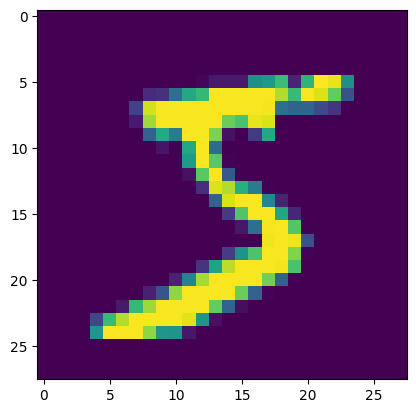

In [ ]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize images to 28x28
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize images
])

class MNISTSubset(Dataset):
    def __init__(self, dataset, digit):
        self.dataset = dataset
        self.data = []
        for img, label in dataset:
            if label == digit:
                self.data.append(img)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize images to 28x28
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize images
])

dataset = datasets.MNIST(root='dataset/', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

dataset_of_5s = MNISTSubset(dataset, digit=5)
dataloader2 = torch.utils.data.DataLoader(dataset_of_5s, batch_size=64, shuffle=True)


print(len(dataset))
print(dataset[0][0].shape)
print(dataset[0][1])
# Plotting the imagex

plt.imshow(dataset[0][0][0])
plt.show()


In [ ]:
# Function to generate and save images
def sample_images(model, diffusion, num_samples=1):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        y = torch.randn(num_samples, 1, 28, 28).to(device)  # Generate random noise
        clas = torch.randint(5, 6, (1,), device=device, dtype=torch.int64)
        print(clas)

        for t in reversed(range(diffusion.num_steps)):  # Reverse diffusion process
            t_batch = torch.tensor([t] * num_samples, device=device).long()  # Time steps batch
            y = diffusion.p_sample(y, t_batch, model, clas)  # Denoise

            # if t % 250 == 0:
            #     plt.imshow(y[0][0])
            #     plt.show()

    return y



In [ ]:

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings #batch_size x dim

class LayerNorm(nn.Module):
    def __init__(self, num_channels, eps=1e-5):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(num_channels, 1, 1))
        self.beta = nn.Parameter(torch.zeros(num_channels, 1, 1))
        self.eps = eps

    def forward(self, x):
        # x shape: (batch, channels, height, width)
        mean = x.mean(dim=1, keepdim=True)
        var = x.var(dim=1, keepdim=True)
        x = (x - mean) / torch.sqrt(var + self.eps)
        return self.gamma * x + self.beta

class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, num_heads=4):
    super(MultiHeadAttention, self).__init__()

    self.d_model = d_model
    self.num_heads = num_heads
    self.head_dim = d_model // num_heads
    self.qkv_layer = nn.Linear(d_model, 3 * d_model)
    self.out_layer = nn.Linear(d_model, d_model)

  def forward(self, x): #batch x channels x h x w (h = w)
    b, c, h, w = x.shape
    x = x.permute(0, 2, 3, 1).contiguous()
    x = x.view(b, h * w, c) #batch x (h x w) x channels
    qkv = self.qkv_layer(x) #batch x (h x w) x 3 * channels
    qkv = qkv.reshape(b, h * w, self.num_heads, 3 * self.head_dim) #b x hw x 8 x ...
    qkv = qkv.permute(0, 2, 1, 3) #b x 8 x hw x ...
    q, k, v = qkv.chunk(3, dim=-1) #b x 8 x hw x ...

    vals = self.compute_attention(q, k, v) #b x 8 x hw x ...
    vals = vals.permute(0, 2, 1, 3).contiguous() #b x hw x 8 x ...
    vals = vals.view(b, h * w, c) #b x hw x channels
    vals = self.out_layer(vals) #b x hw x channels
    vals = vals.permute(0, 2, 1) #b x channels x hw x ...
    vals = vals.reshape(b, c, h, w) #b x h x w x channels
    return vals


  def compute_attention(self, q, k, v): # each 32 x 8 x 21 x 64
    d_k = q.size()[-1]
    attention = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)# 32 x 8 x 21 x 21
    attention = torch.softmax(attention, dim=-1) #along columns to rows sum to 1
    vals = torch.matmul(attention, v) #32 x 8 x 21 x 64
    return vals


class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()

    self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(32),
            nn.Linear(32, 32),
            nn.ReLU()
        )
    self.class_embedding = nn.Embedding(10, 32)

    self.linear1 = nn.Linear(32, 1)
    self.encoder1 = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
    )
    self.maxpool = nn.MaxPool2d(2)

    self.MultiHeadAttention = MultiHeadAttention(64)
    self.norm1 = LayerNorm(64)


    self.linear2 = nn.Linear(32, 64)
    self.encoder2 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(),
    )

    self.MultiHeadAttention2 = MultiHeadAttention(128)
    self.norm2 = LayerNorm(128)

    self.linear3 = nn.Linear(32, 128)
    self.bottleneck = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(256, 256, 2, stride=2, padding=0)
    )

    self.MultiHeadAttention3 = MultiHeadAttention(256)
    self.norm3 = LayerNorm(256)

    self.linear4 = nn.Linear(32, 384)
    self.decoder1 = nn.Sequential(
        nn.Conv2d(384, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(128, 128, 2, stride=2, padding=0)
    )

    self.MultiHeadAttention4 = MultiHeadAttention(128)
    self.norm4 = LayerNorm(128)

    self.linear5 = nn.Linear(32, 192)
    self.decoder2 = nn.Sequential(
        nn.Conv2d(192, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
    )

  def forward(self, x, t, classes):

    t = self.time_mlp(t) #[batch_size x 32]
    c = self.class_embedding(classes) #[batch_size x 32]
    t = t + c

    t_emb = self.linear1(t) #[batch_size x 1]
    t_emb = t_emb[:, :, None, None] #[batch_size x 1 x 28 x 28]
    residual_1 = self.encoder1(x + t_emb)
    x = self.maxpool(residual_1)

    # resid_x = self.norm1(x)
    # x = self.MultiHeadAttention(resid_x)
    # x = self.norm1(x)
    # x = x + resid_x

    t_emb = self.linear2(t) #[batch_size x 64]
    t_emb = t_emb[:, :, None, None]
    residual_2 = self.encoder2(x + t_emb)
    x = self.maxpool(residual_2)


    # resid_x = self.norm2(x)
    # x = self.MultiHeadAttention2(resid_x)
    # x = self.norm2(x)
    # x = x + resid_x

    t_emb = self.linear3(t) #[batch_size x 128]
    t_emb = t_emb[:, :, None, None]
    x = self.bottleneck(x + t_emb)

    # resid_x = self.norm3(x)
    # x = self.MultiHeadAttention3(resid_x)
    # x = self.norm3(x)
    # x = x + resid_x

    x = torch.cat([x, residual_2], dim=1)
    t_emb = self.linear4(t)
    t_emb = t_emb[:, :, None, None]
    x = self.decoder1(x + t_emb)

    # resid_x = self.norm4(x)
    # x = self.MultiHeadAttention4(resid_x)
    # x = self.norm4(x)
    # x = x + resid_x

    x = torch.cat([x, residual_1], dim=1)
    t_emb = self.linear5(t)
    t_emb = t_emb[:, :, None, None]
    x = self.decoder2(x + t_emb)

    return x

class Diffusion():
  def __init__(self, num_steps=1000):
    super(Diffusion, self).__init__()
    self.num_steps = num_steps
    # self.beta = np.linspace(0.0001, 0.02, num_steps)
    self.beta = self.cos_schedule()
    self.beta = torch.tensor(self.beta, dtype=torch.float32)
    self.alpha = 1.0 - self.beta
    self.alpha_bar = torch.tensor(np.cumprod(self.alpha), dtype=torch.float32)
    self.beta = self.beta.to(device)
    self.alpha = self.alpha.to(device)
    self.alpha_bar = self.alpha_bar.to(device)

  def cos_schedule(self, s=0.008):
      steps = np.arange(self.num_steps + 1, dtype=np.float64)
      x = steps / self.num_steps
      alphas_cumprod = np.cos(((x + s) / (1 + s)) * np.pi * 0.5) ** 2
      alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
      betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
      return np.clip(betas, 0, 0.999)

  def q_sample(self, x_0, t, noise=None):
    batch_size = len(x_0)
    if noise is None:
      noise = torch.randn_like(x_0)

    noise = noise.to(device)
    t = t.to(device)
    x_0 = x_0.to(device)

    a = torch.sqrt(self.alpha_bar[t]).view(batch_size, 1, 1, 1)

    return torch.sqrt(self.alpha_bar[t]).view(batch_size, 1, 1, 1) * x_0 + torch.sqrt(1 - self.alpha_bar[t]).view(batch_size, 1, 1, 1) * noise

  def p_sample(self, x_t, t, model, clas):
    with torch.no_grad():
      batch_size = len(x_t)
      if t[0] <= 1:
        noise = torch.zeros_like(x_t)
      else:
        noise = torch.randn_like(x_t)

      predictions = model(x_t, t, clas) #batch x 1 x 28 x 28

    t = t.to(device)
    clas = clas.to(device)
    noise = noise.to(device)
    predictions = predictions.to(device)

    x_prev = (1 / torch.sqrt(self.alpha[t])) * (x_t - (1 - self.alpha[t]) / torch.sqrt(1 - self.alpha_bar[t]) * predictions) + torch.sqrt(self.beta[t]) * noise
    return x_prev



In [ ]:
unet = UNet()
unet = torch.compile(unet)
unet.to(device)
diffusion = Diffusion(num_steps=1000)
epochs = 10
criterion = nn.L1Loss(reduction="mean")
ccrit = nn.L1Loss(reduction="mean")
optimizer = optim.AdamW(unet.parameters(), lr=0.0005, )
torch.manual_seed(123)
schedulerd = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.75)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, verbose=True)

<ipython-input-10-30f8b1128819>:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.alpha_bar = torch.tensor(np.cumprod(self.alpha), dtype=torch.float32)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


tensor([5], device='cuda:0')


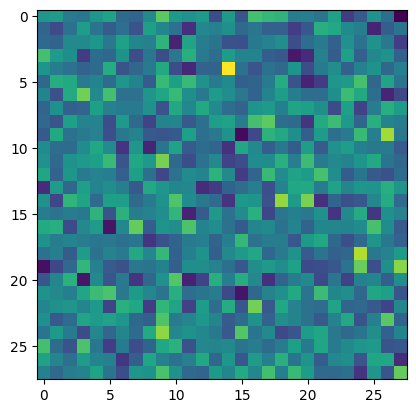

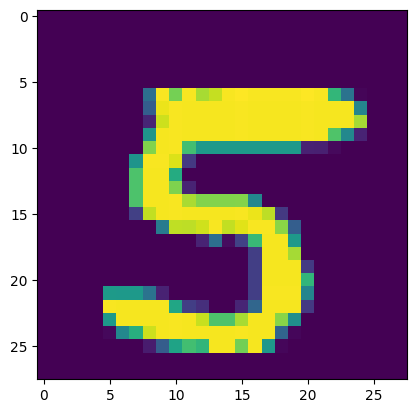

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([64, 1, 28, 28])) that is different to the input size (torch.Size([1, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


0
0.8801100254058838
validation loss: 14954.7470703125
tensor([5], device='cuda:0')


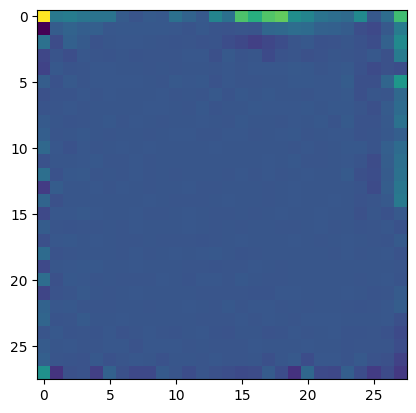

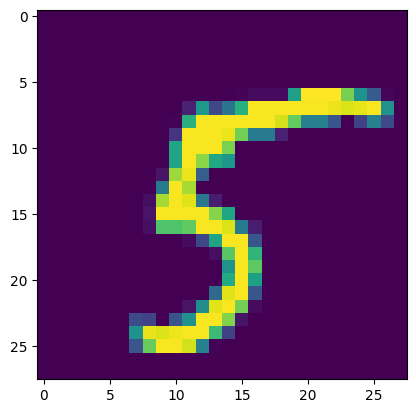

25
0.2623414099216461
validation loss: 71.69369506835938
tensor([5], device='cuda:0')


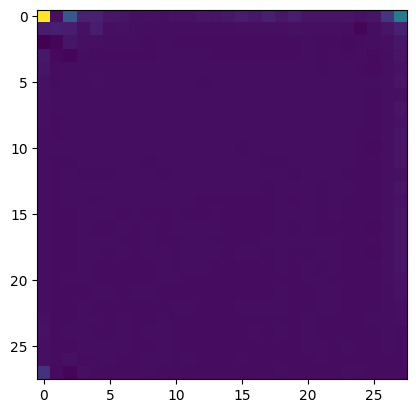

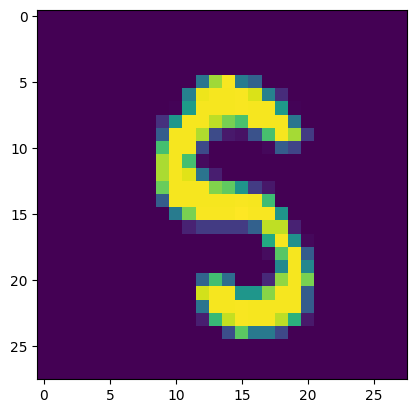

50
0.20809310674667358
validation loss: 9.090359687805176
tensor([5], device='cuda:0')


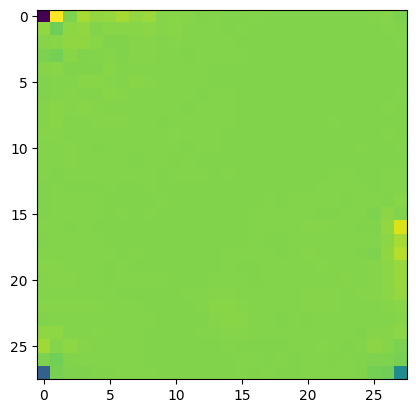

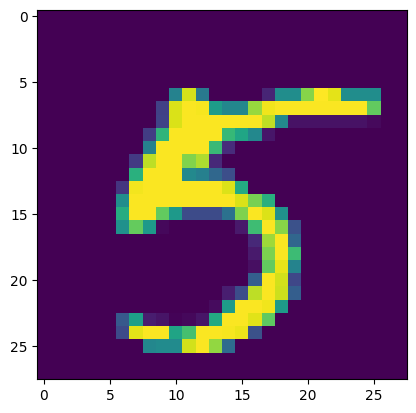

75
0.21015384793281555
validation loss: 1.0880346298217773
tensor([5], device='cuda:0')


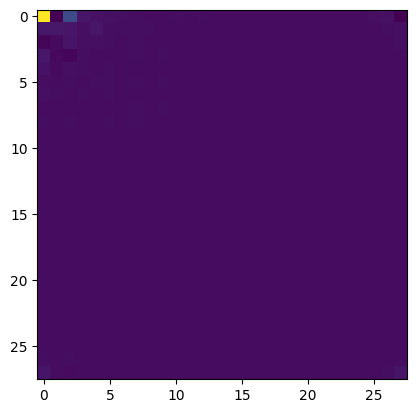

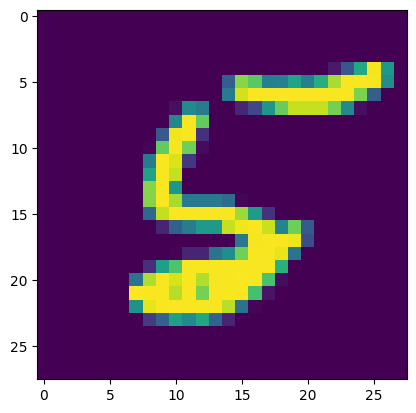

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([64, 1, 28, 28])) that is different to the input size (torch.Size([1, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


0
0.18937939405441284
validation loss: 4.732823371887207
tensor([5], device='cuda:0')


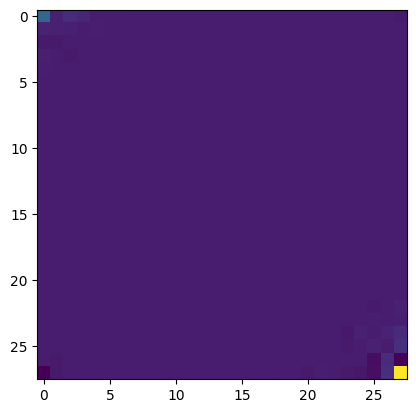

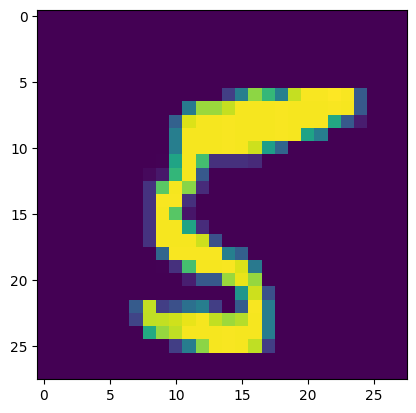

25
0.1909005492925644
validation loss: 4.453199863433838
tensor([5], device='cuda:0')


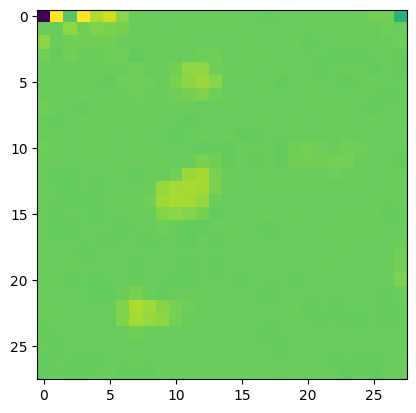

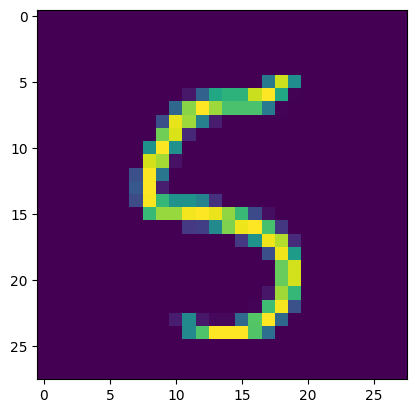

50
0.17707586288452148
validation loss: 0.3689896762371063
tensor([5], device='cuda:0')


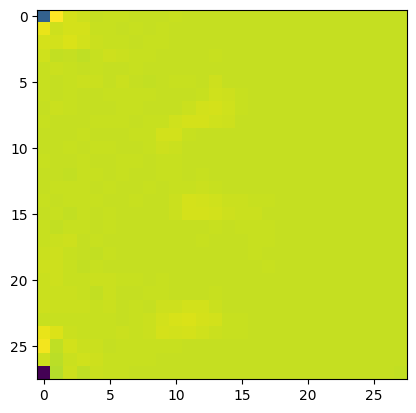

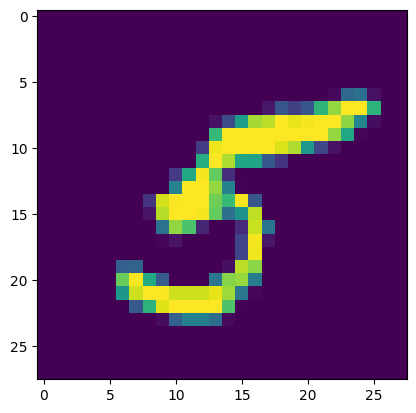

75
0.18950362503528595
validation loss: 0.571868360042572
tensor([5], device='cuda:0')


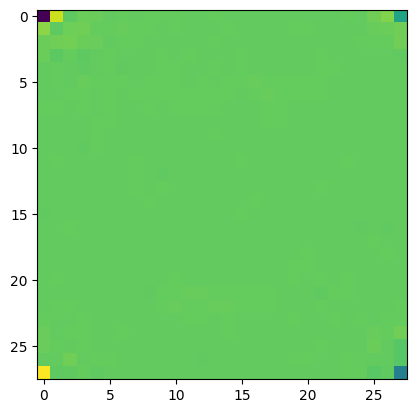

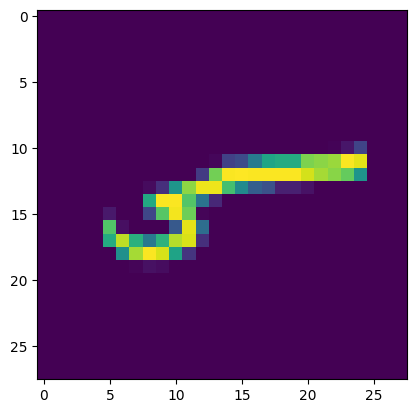

0
0.16639912128448486
validation loss: 1.3601523637771606
tensor([5], device='cuda:0')


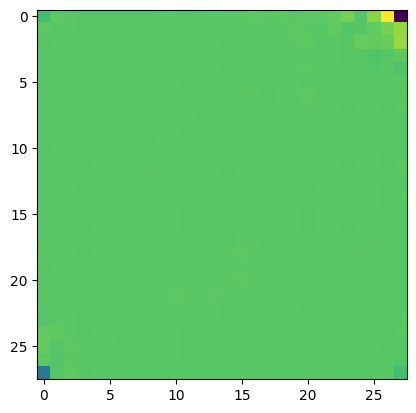

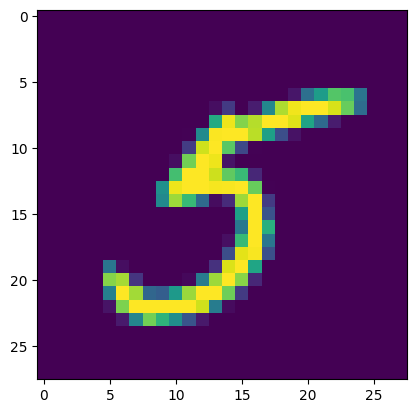

25
0.16081149876117706
validation loss: 1.5260677337646484
tensor([5], device='cuda:0')


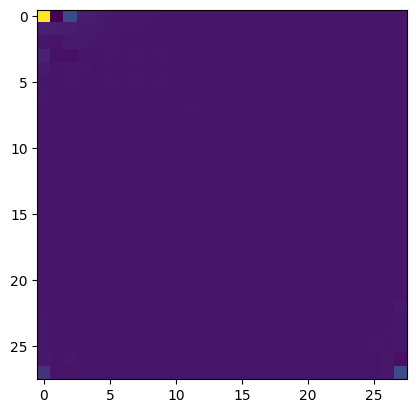

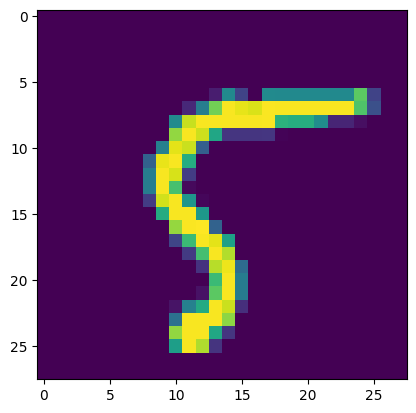

50
0.15928290784358978
validation loss: 2.538133144378662
tensor([5], device='cuda:0')


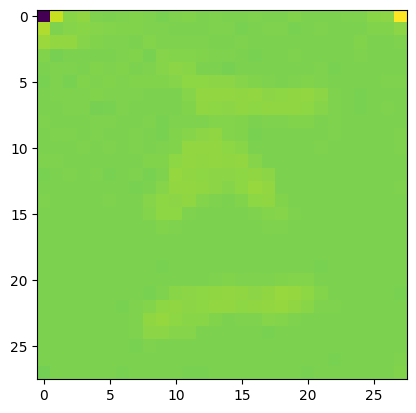

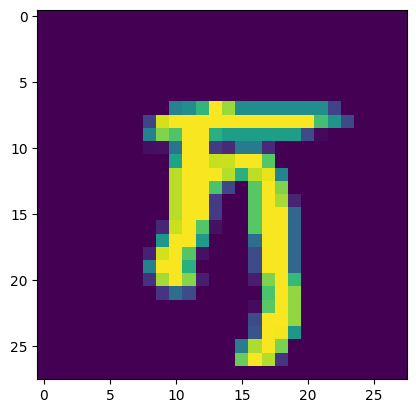

75
0.15881553292274475
validation loss: 0.4663921296596527
tensor([5], device='cuda:0')


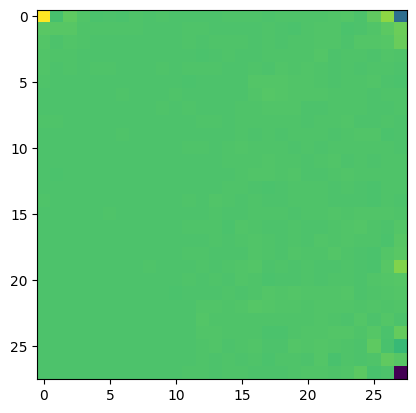

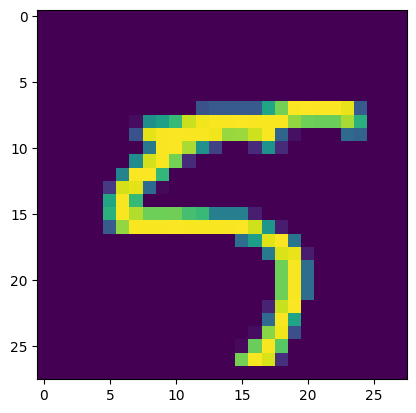

0
0.1739344596862793
validation loss: 0.8179164528846741
tensor([5], device='cuda:0')


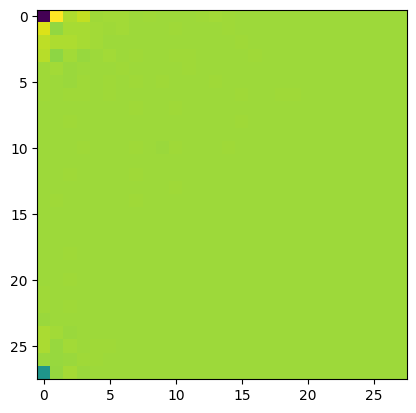

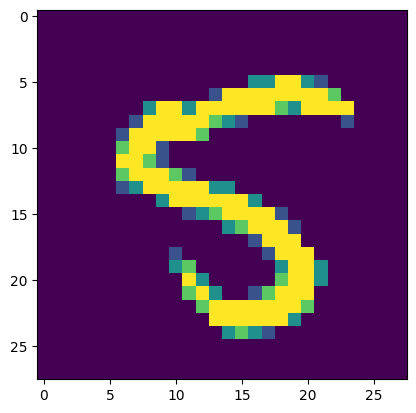

25
0.1841842532157898
validation loss: 1.8365761041641235
tensor([5], device='cuda:0')


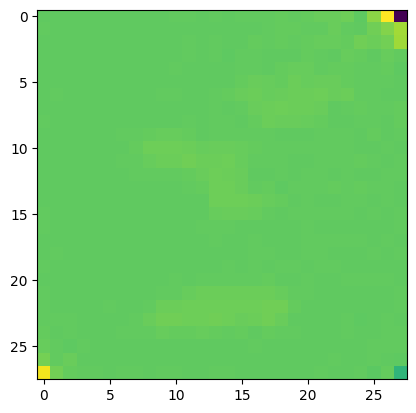

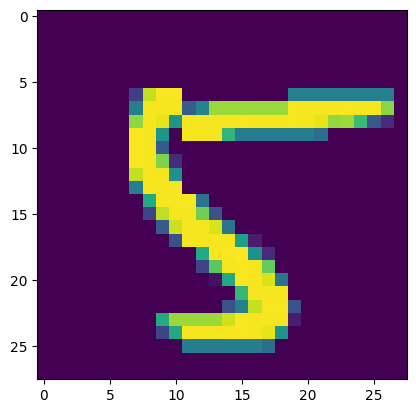

50
0.15526250004768372
validation loss: 0.5824063420295715
tensor([5], device='cuda:0')


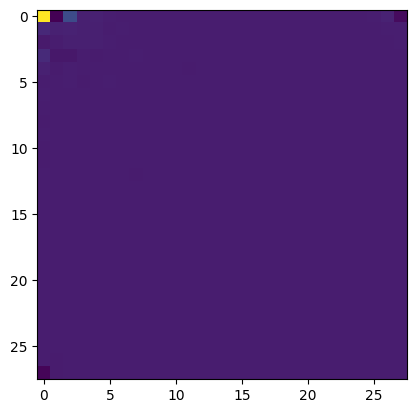

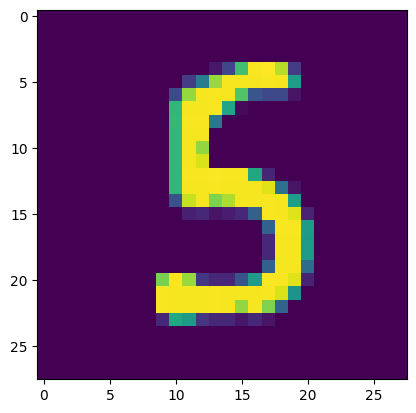

75
0.18162792921066284
validation loss: 2.9491641521453857
tensor([5], device='cuda:0')


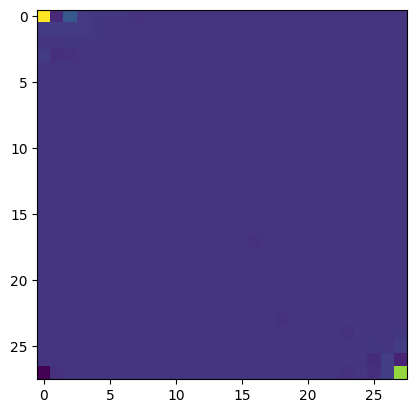

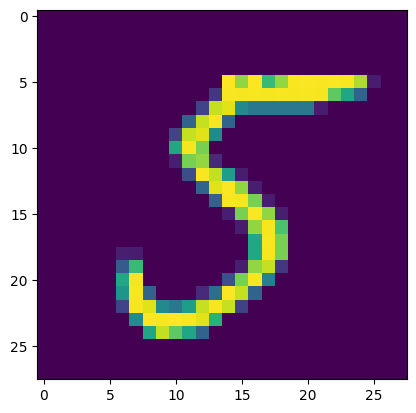

0
0.16366833448410034
validation loss: 1.340208649635315
tensor([5], device='cuda:0')


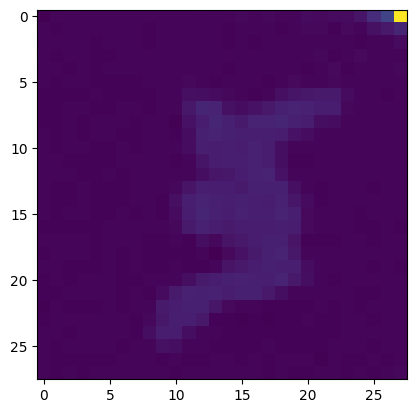

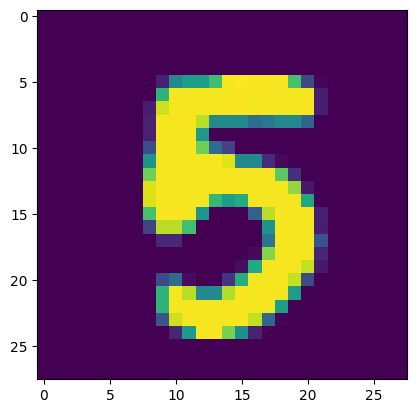

25
0.15347282588481903
validation loss: 0.4048217833042145
tensor([5], device='cuda:0')


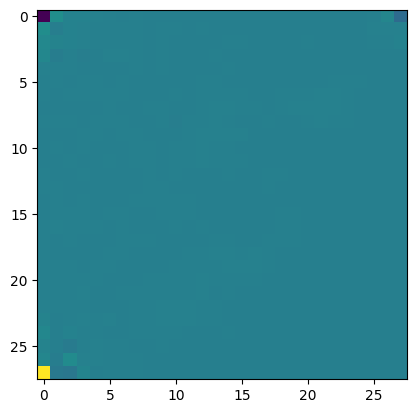

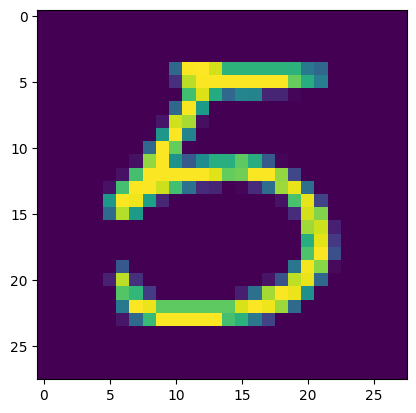

50
0.16689638793468475
validation loss: 1.0145900249481201
tensor([5], device='cuda:0')


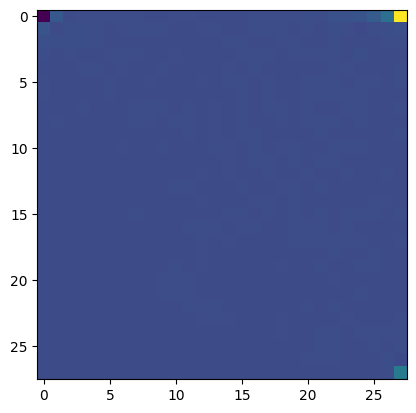

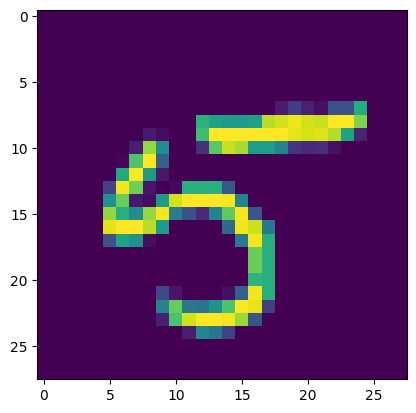

75
0.1822081357240677
validation loss: 1.8816250562667847
tensor([5], device='cuda:0')


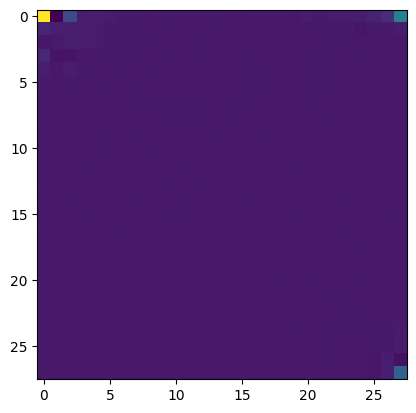

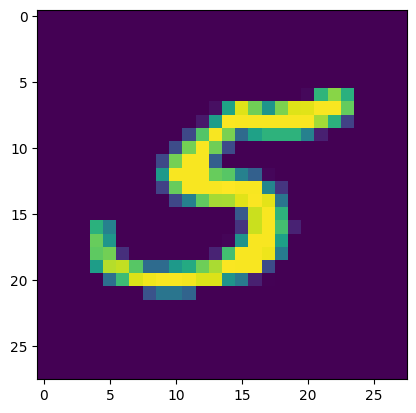

0
0.16401048004627228
validation loss: 5.90760612487793
tensor([5], device='cuda:0')


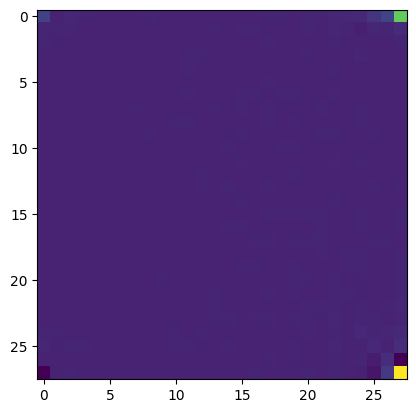

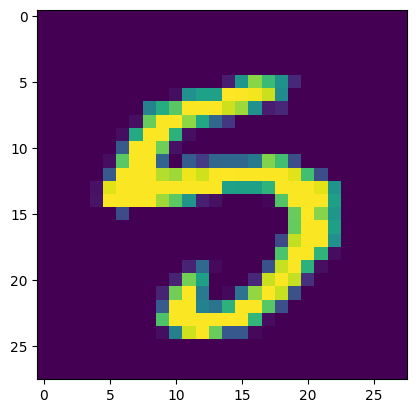

25
0.16299401223659515
validation loss: 2.2892346382141113
tensor([5], device='cuda:0')


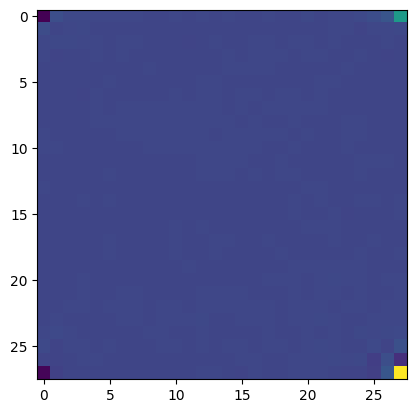

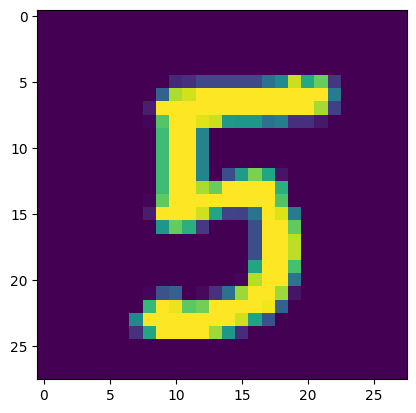

50
0.18164877593517303
validation loss: 1.5474168062210083
tensor([5], device='cuda:0')


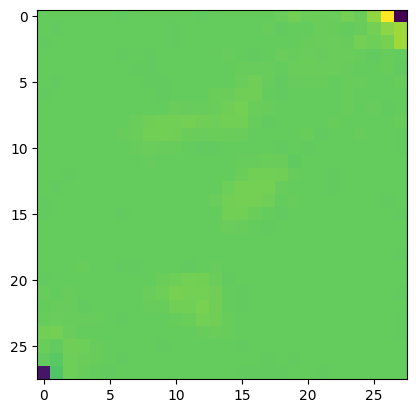

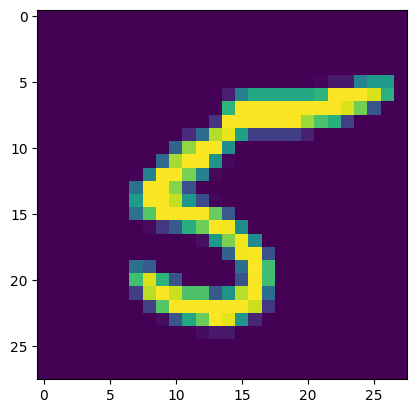

75
0.16878752410411835
validation loss: 0.5439812541007996
tensor([5], device='cuda:0')


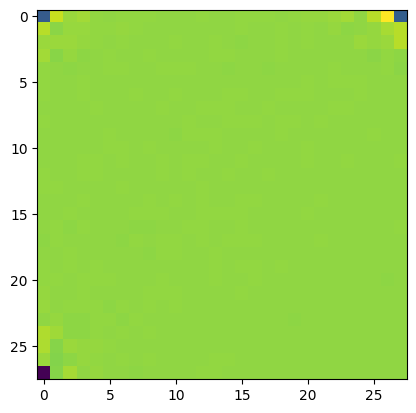

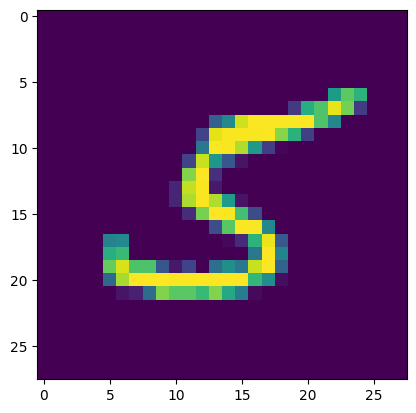

0
0.15143370628356934
validation loss: 1.876732349395752
tensor([5], device='cuda:0')


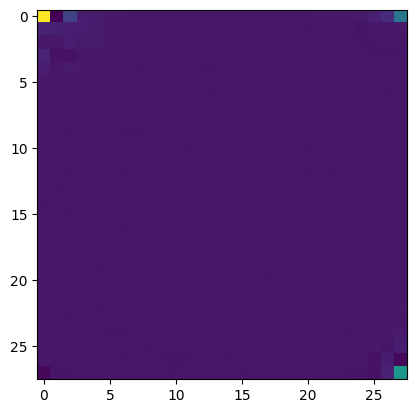

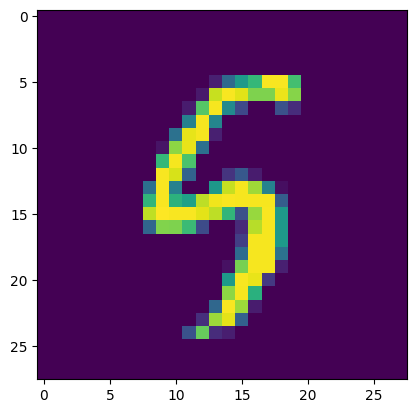

25
0.15083305537700653
validation loss: 2.2734575271606445
tensor([5], device='cuda:0')


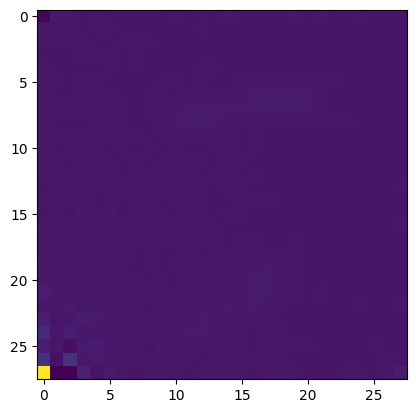

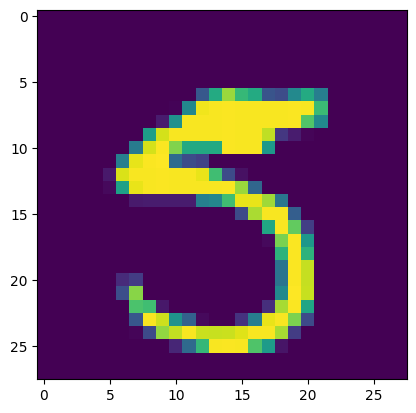

50
0.15990982949733734
validation loss: 0.7739974856376648
tensor([5], device='cuda:0')


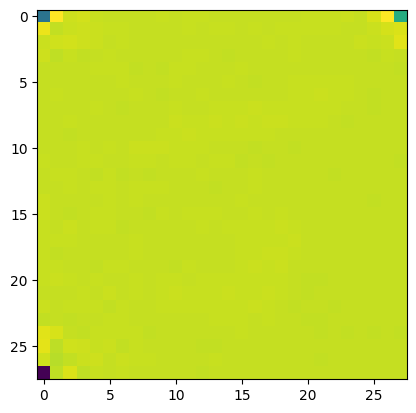

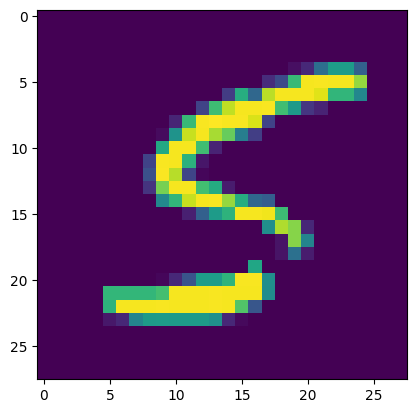

75
0.15437421202659607
validation loss: 1.2701212167739868
tensor([5], device='cuda:0')


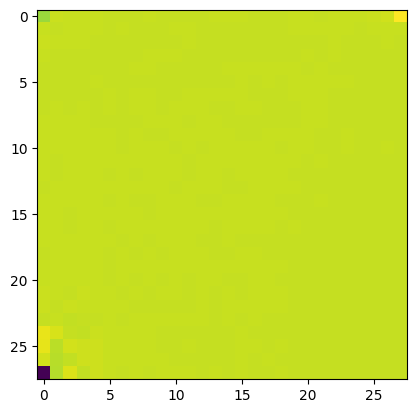

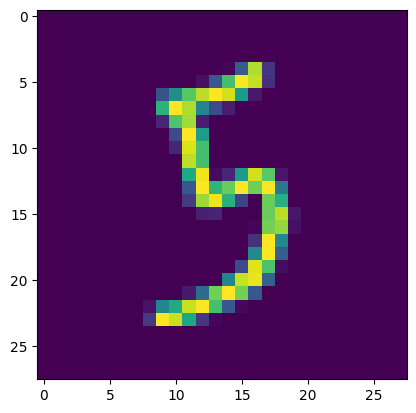

0
0.19685079157352448
validation loss: 2.4586684703826904
tensor([5], device='cuda:0')


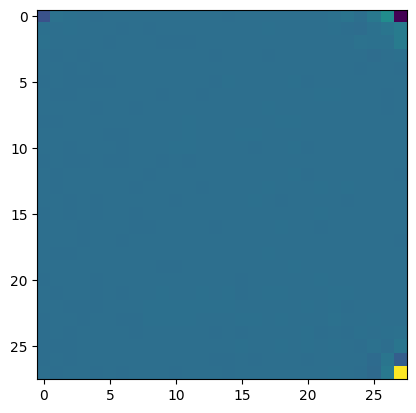

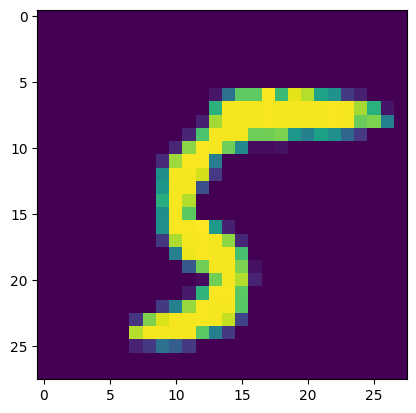

25
0.18005035817623138
validation loss: 1.2654998302459717
tensor([5], device='cuda:0')


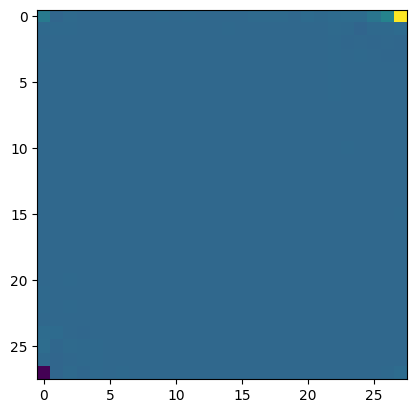

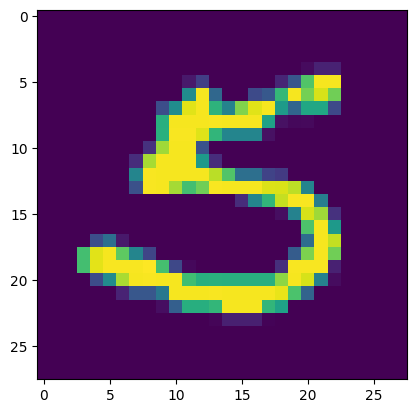

50
0.1794639527797699
validation loss: 3.3774313926696777
tensor([5], device='cuda:0')


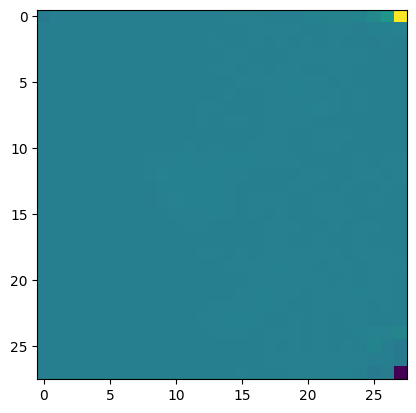

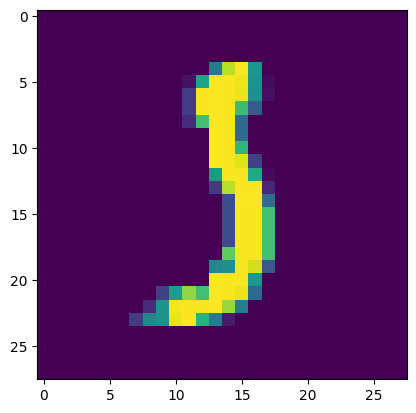

75
0.17357291281223297
validation loss: 0.8041149377822876
tensor([5], device='cuda:0')


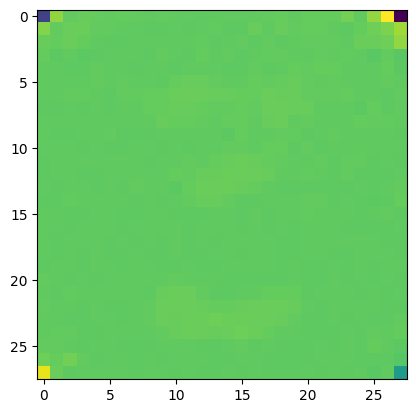

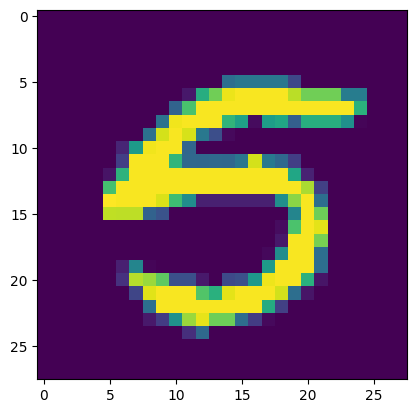

0
0.17591553926467896
validation loss: 0.7672122120857239
tensor([5], device='cuda:0')


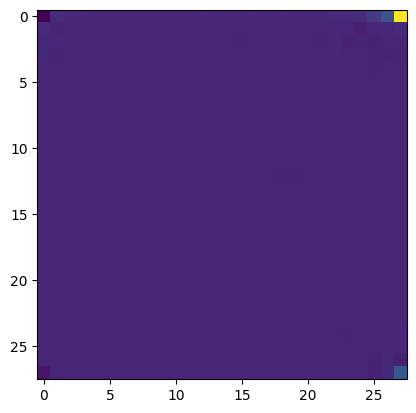

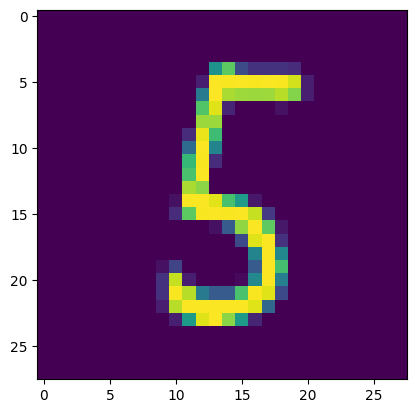

25
0.18518038094043732
validation loss: 3.3437306880950928
tensor([5], device='cuda:0')


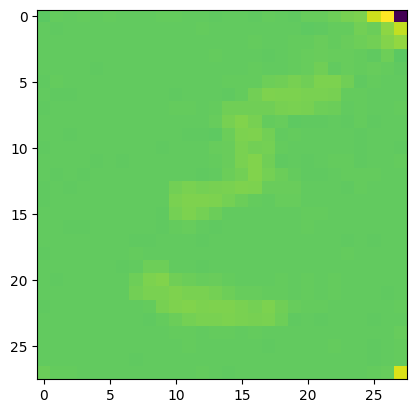

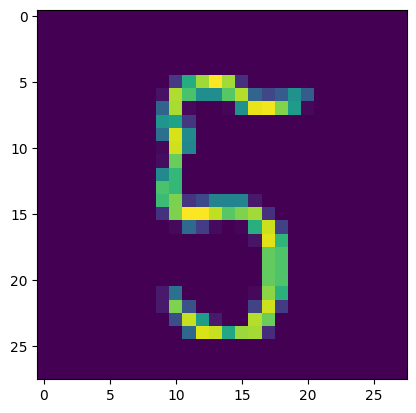

50
0.15856115520000458
validation loss: 0.41656047105789185
tensor([5], device='cuda:0')


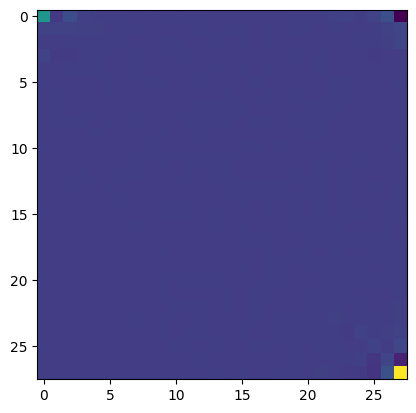

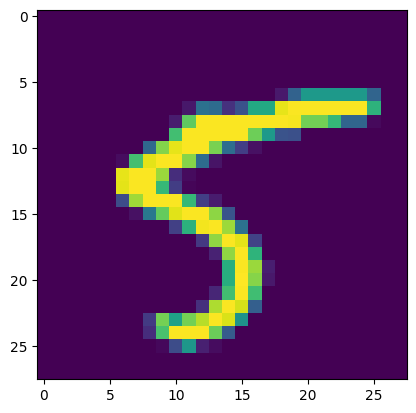

75
0.15145383775234222
validation loss: 2.5945937633514404
tensor([5], device='cuda:0')


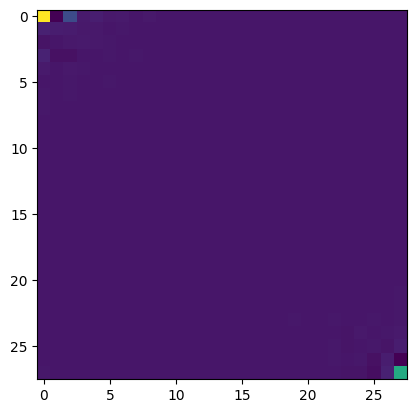

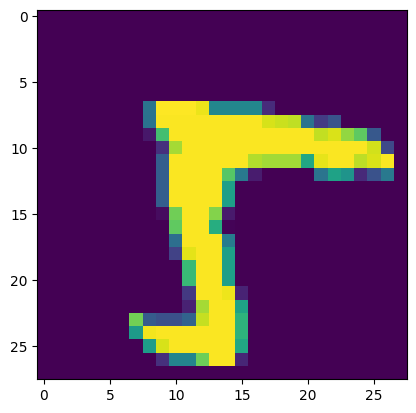

0
0.15949061512947083
validation loss: 5.161694526672363
tensor([5], device='cuda:0')


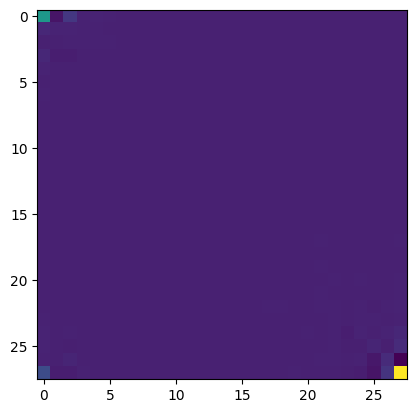

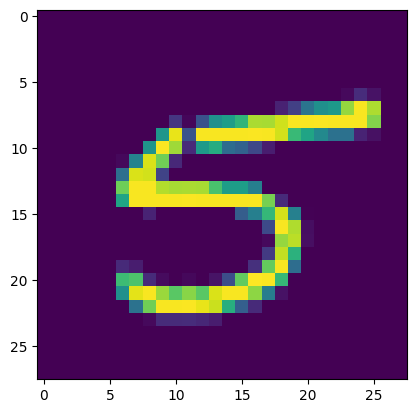

25
0.17633244395256042
validation loss: 3.338684320449829
tensor([5], device='cuda:0')


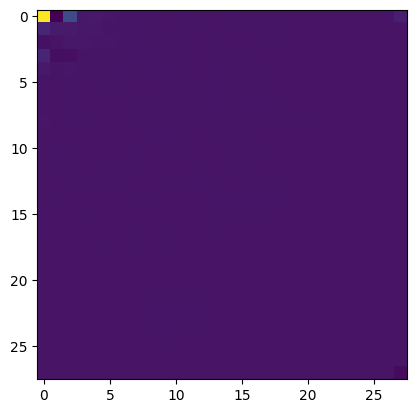

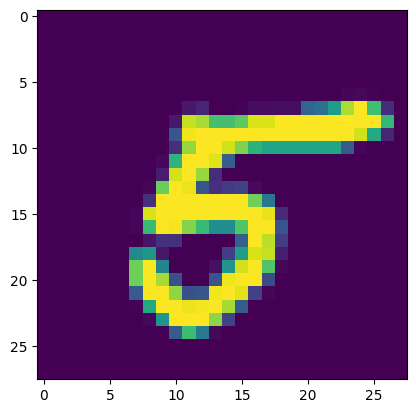

50
0.1849781721830368
validation loss: 1.9742335081100464
tensor([5], device='cuda:0')


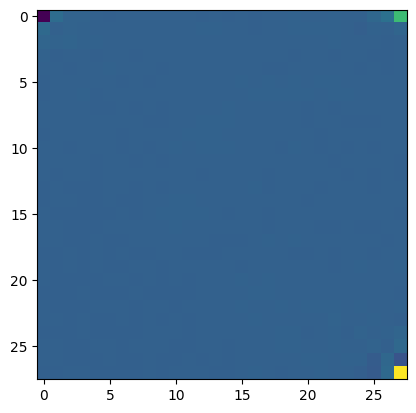

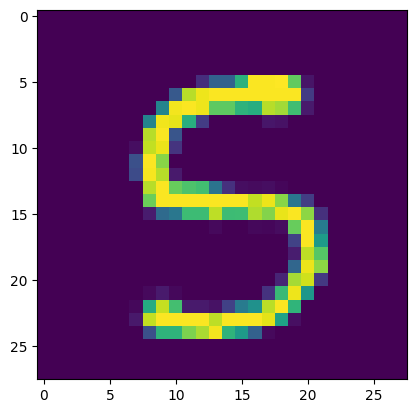

75
0.15955430269241333
validation loss: 1.1026718616485596


In [ ]:
for epoch in range(epochs):
  for i, (x) in enumerate(dataloader2):
    # x = dataset[0][0]
    # x = x.unsqueeze(0)
    # x = x.expand(64, -1, -1, -1)
    x = x.to(device)
    # plt.imshow(x[0][0].cpu())
    # plt.show()

    # y = y.to(device)

    unet.train()
    batch_size = len(x)

    #forward
    t = torch.randint(0, diffusion.num_steps, (batch_size,), device=device, dtype=torch.int64)
    y = torch.randint(5, 6, (batch_size,), device=device, dtype=torch.int64)
    noise = torch.randn_like(x)
    noise = noise.to(device)

    noisy_images = diffusion.q_sample(x, t, noise)
    noisy_images = noisy_images.to(device)
    predicts = unet(noisy_images, t, y)
    predicts = predicts.to(device)

    loss = criterion(predicts, noise)
    loss.backward()

    #backward
    torch.nn.utils.clip_grad_norm_(unet.parameters(), max_norm=1.0)
    optimizer.step()
    optimizer.zero_grad()
    schedulerd.step()

    if i % 25 == 0:
      with torch.no_grad():
        z = sample_images(unet, diffusion, num_samples=1)
        plt.imshow(z[0][0].cpu())
        plt.show()

        plt.imshow(x[0][0].cpu())
        plt.show()

        val_loss = ccrit(z, x)
        print(i)
        print(loss.item())
        print(f'validation loss: {val_loss.item()}')
        # scheduler.step(val_loss)



In [ ]:
x = sample_images(unet, diffusion, num_samples=1)

plt.imshow(x[0][0])
plt.show()
plt.imshow(dataset[0][0][0])
plt.show()

